In [1]:
# Import Libaries and Tools
import os
import sys
from astropy.io import fits
import sunpy.map
from aiapy.calibrate import register, update_pointing
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import glob

# ACWE utilities
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import ACWE Tools
sys.path.append(ROOT_DIR)
from ACWE_python_spring_2023 import acweSaveSeg_v5, acweRestoreScale
from DatasetTools import DataManagmentTools as dmt
from Intensity import pngScale2

In [2]:
# File
dataset = '/home/jgra/Coronal Holes/newDataset/'
ImageNames = ['CR2099/2010-07-25T120002Z/aia.lev1_euv_12s.2010-07-25T120009Z.193.image_lev1.fits',
              'CR2100/2010-08-21T220002Z/aia.lev1_euv_12s.2010-08-21T220009Z.193.image_lev1.fits',
              'CR2101/2010-09-18T000002Z/aia.lev1_euv_12s.2010-09-18T000008Z.193.image_lev1.fits',
              'CR2133/2013-02-21T230001Z/aia.lev1_euv_12s.2013-02-21T230008Z.193.image_lev1.fits']

# ACWE Folders
saveFolderIntInv  = '/mnt/coronal_holes/Code Paper I Observations/IntInv/'
saveFolderDefault = '/mnt/coronal_holes/CodeVI Observations/Standard/'

# Intensity Scaling Parameters
# scale types = [[min,max,scaletype,"restore"forAcWE,scaleName]]
scaleTypes = [["Imin","Imax","linear",False,"LinearCompressFull."               ,"Linear Full"                      ],
              ["Imin","Imax","linear",True ,"LinearCompressFullRestored."       ,"Linear Full Restored"             ],
              [0     ,"Imax","Linear",False,"LinearCompress0toMax."             ,"Linear 0 to Max"                  ],
              [0     ,"Imax","linear",True ,"LinearCompress0toMaxRestored."     ,"Linear 0 to Max Restored"         ],
              ["Smin","Smax","linear",False,"LinearCompressSolarLimits."        ,"Linear Solar Limits"              ],
              ["Smin","Smax","linear",True ,"LinearCompressSolarLimitsRestored.","Linear Solar Limits Restored"     ],
              [20.0  ,2500.0,"linear",False,"LinearCompressDefault."            ,"Linear Default"                   ],
              [20.0  ,2500.0,"linear",True ,"LinearCompressDefaultRestored."    ,"Linear Default Restored"          ],
              ["Imin","Imax","log10", False,"Log10CompressFull."                ,"$\log_{10}$ Full"                 ],
              ["Imin","Imax","log10", True ,"Log10CompressFullRestored."        ,"$\log_{10}$ Full Restored"        ],
              [0     ,"Imax","log10" ,False,"Log10Compress0toMax."              ,"$\log_{10}$ 0 to Max"             ],
              [0     ,"Imax","log10" ,True ,"Log10Compress0toMaxRestored."      ,"$\log_{10}$ 0 to Max Restored"    ],
              ["Smin","Smax","log10" ,False,"Log10CompressSolarLimits."         ,"$\log_{10}$ Solar Limits"         ],
              ["Smin","Smax","log10" ,True ,"Log10CompressSolarLimitsRestored." ,"$\log_{10}$ Solar Limits Restored"],
              [20.0  ,2500.0,"log10" ,False,"Log10CompressDefault."             ,"$\log_{10}$ 20 to 2500"           ],
              [20.0  ,2500.0,"log10" ,True ,"Log10CompressDefaultRestored."     ,"$\log_{10}$ 20 to 2500 Restored"  ]]

In [3]:
# Open File and Prepare for ACWE
def openAIA(filename):
    
    # Extract Image and Header Data
    hdulist = fits.open(filename)
    hdulist.verify('silentfix') # no clue why this is needed for successful data read
    h = hdulist[1].header
    J = hdulist[1].data
    hdulist.close()
    
    # Update to Level 1.5 Data Product
    if h['LVL_NUM'] < 1.5:
        m = sunpy.map.Map((J,h))    # Create Sunpy Map
        m = update_pointing(m)      # Update Header based on Latest Information
        m_registrered = register(m) # Recenter and rotate to Solar North
        I = m_registrered.data
        # Undo Keword Renaming
        H = dict()
        for k in m_registrered.meta.keys(): 
            H[k.upper()] = m_registrered.meta[k] 
    # Skip if already Level 1.5
    else:
        # Convert header to dictionary
        m = sunpy.map.Map((J,h)) # Create Map
        H = dict()
        for k in m.meta.keys():
            h[k.upper()] = m.meta[k]
        I = J*1 # Copy image
        
    # Prepare Display Version
    Idsp = np.clip(I,20,2500)
    Idsp = np.log10(Idsp)
    Idsp = Idsp - np.min(Idsp)
    Idsp = Idsp/np.max(Idsp)
    
    return I,Idsp,H

def make_circle_mask(c,im_dims,r):
    # defomes a binary image with image dimensions im_dims of a circle with 
    # center c and radius r
    cx = c[0]
    cy = c[1]
    ix = im_dims[0]
    iy = im_dims[1]
    x,y = np.meshgrid(np.arange(-(cx),(ix-cx),1),np.arange(-(cy),(iy-cy),1))
    c_mask = (x**2+y**2)<=r**2
    return c_mask

In [4]:
# Ensure Folder Exists
saveDirectory = '/Figures/IntConstancy/'
saveDirectory = ROOT_DIR + saveDirectory

if not os.path.exists(saveDirectory):
    os.makedirs(saveDirectory)

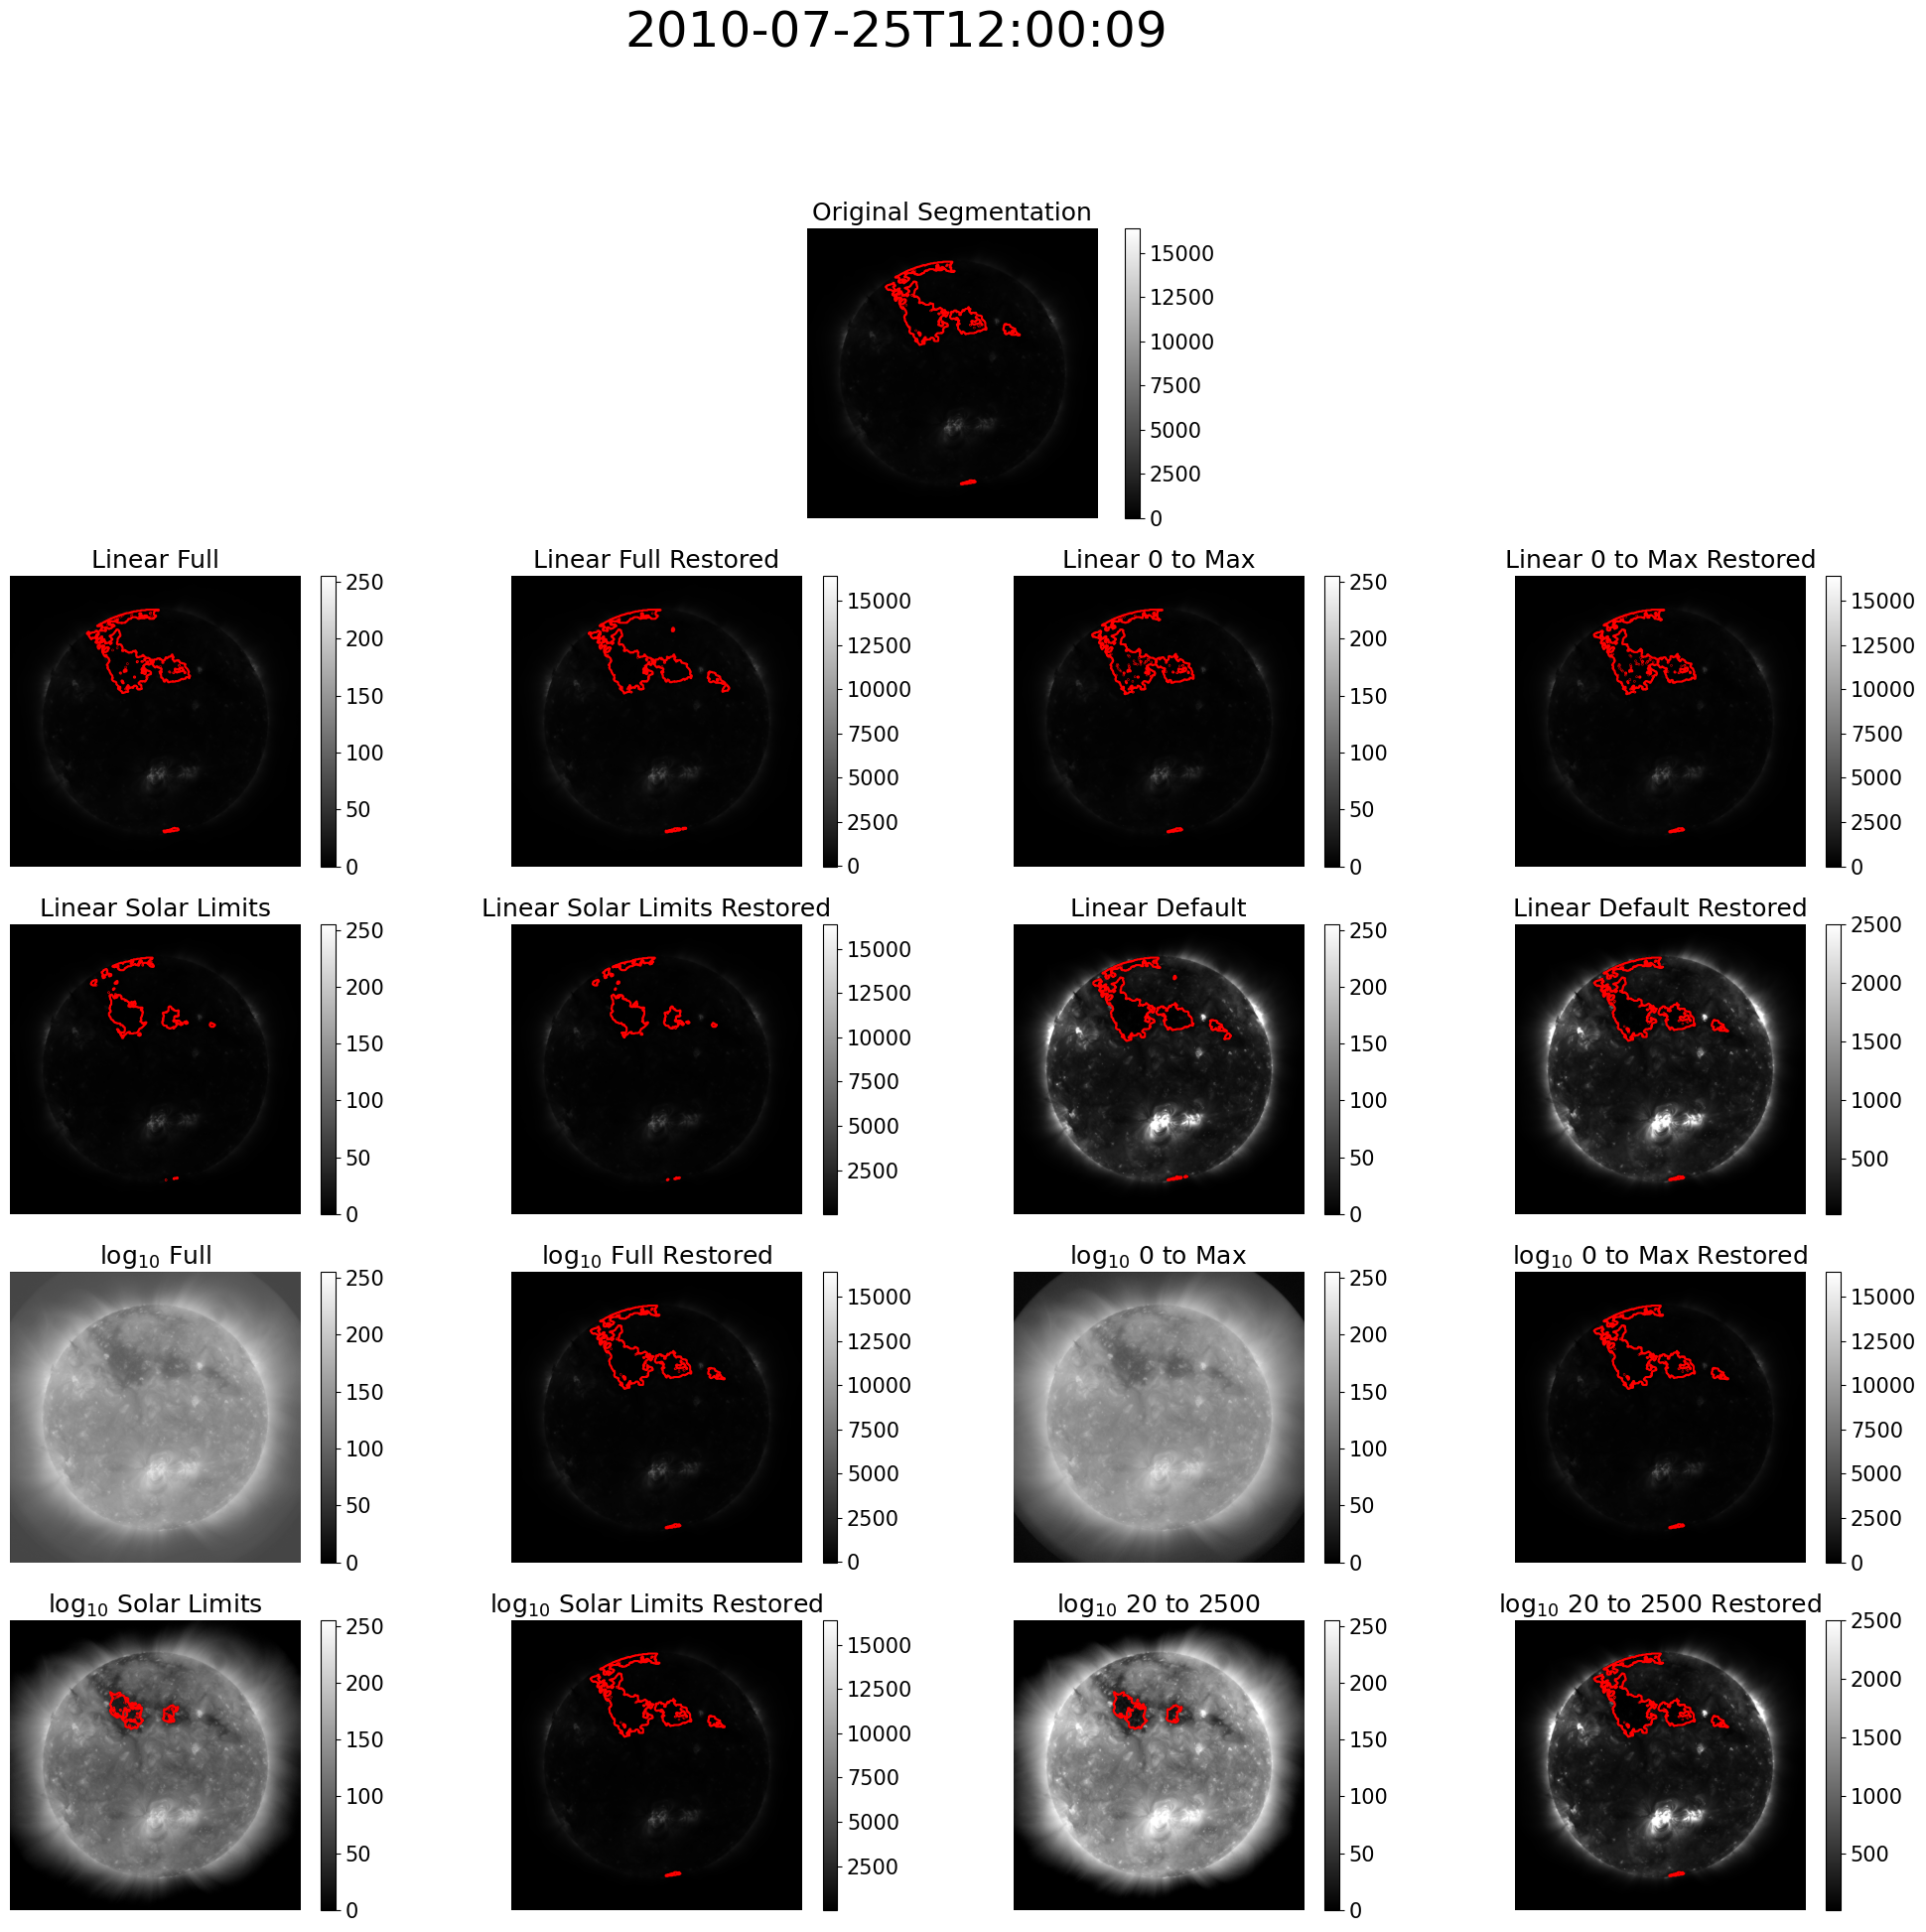

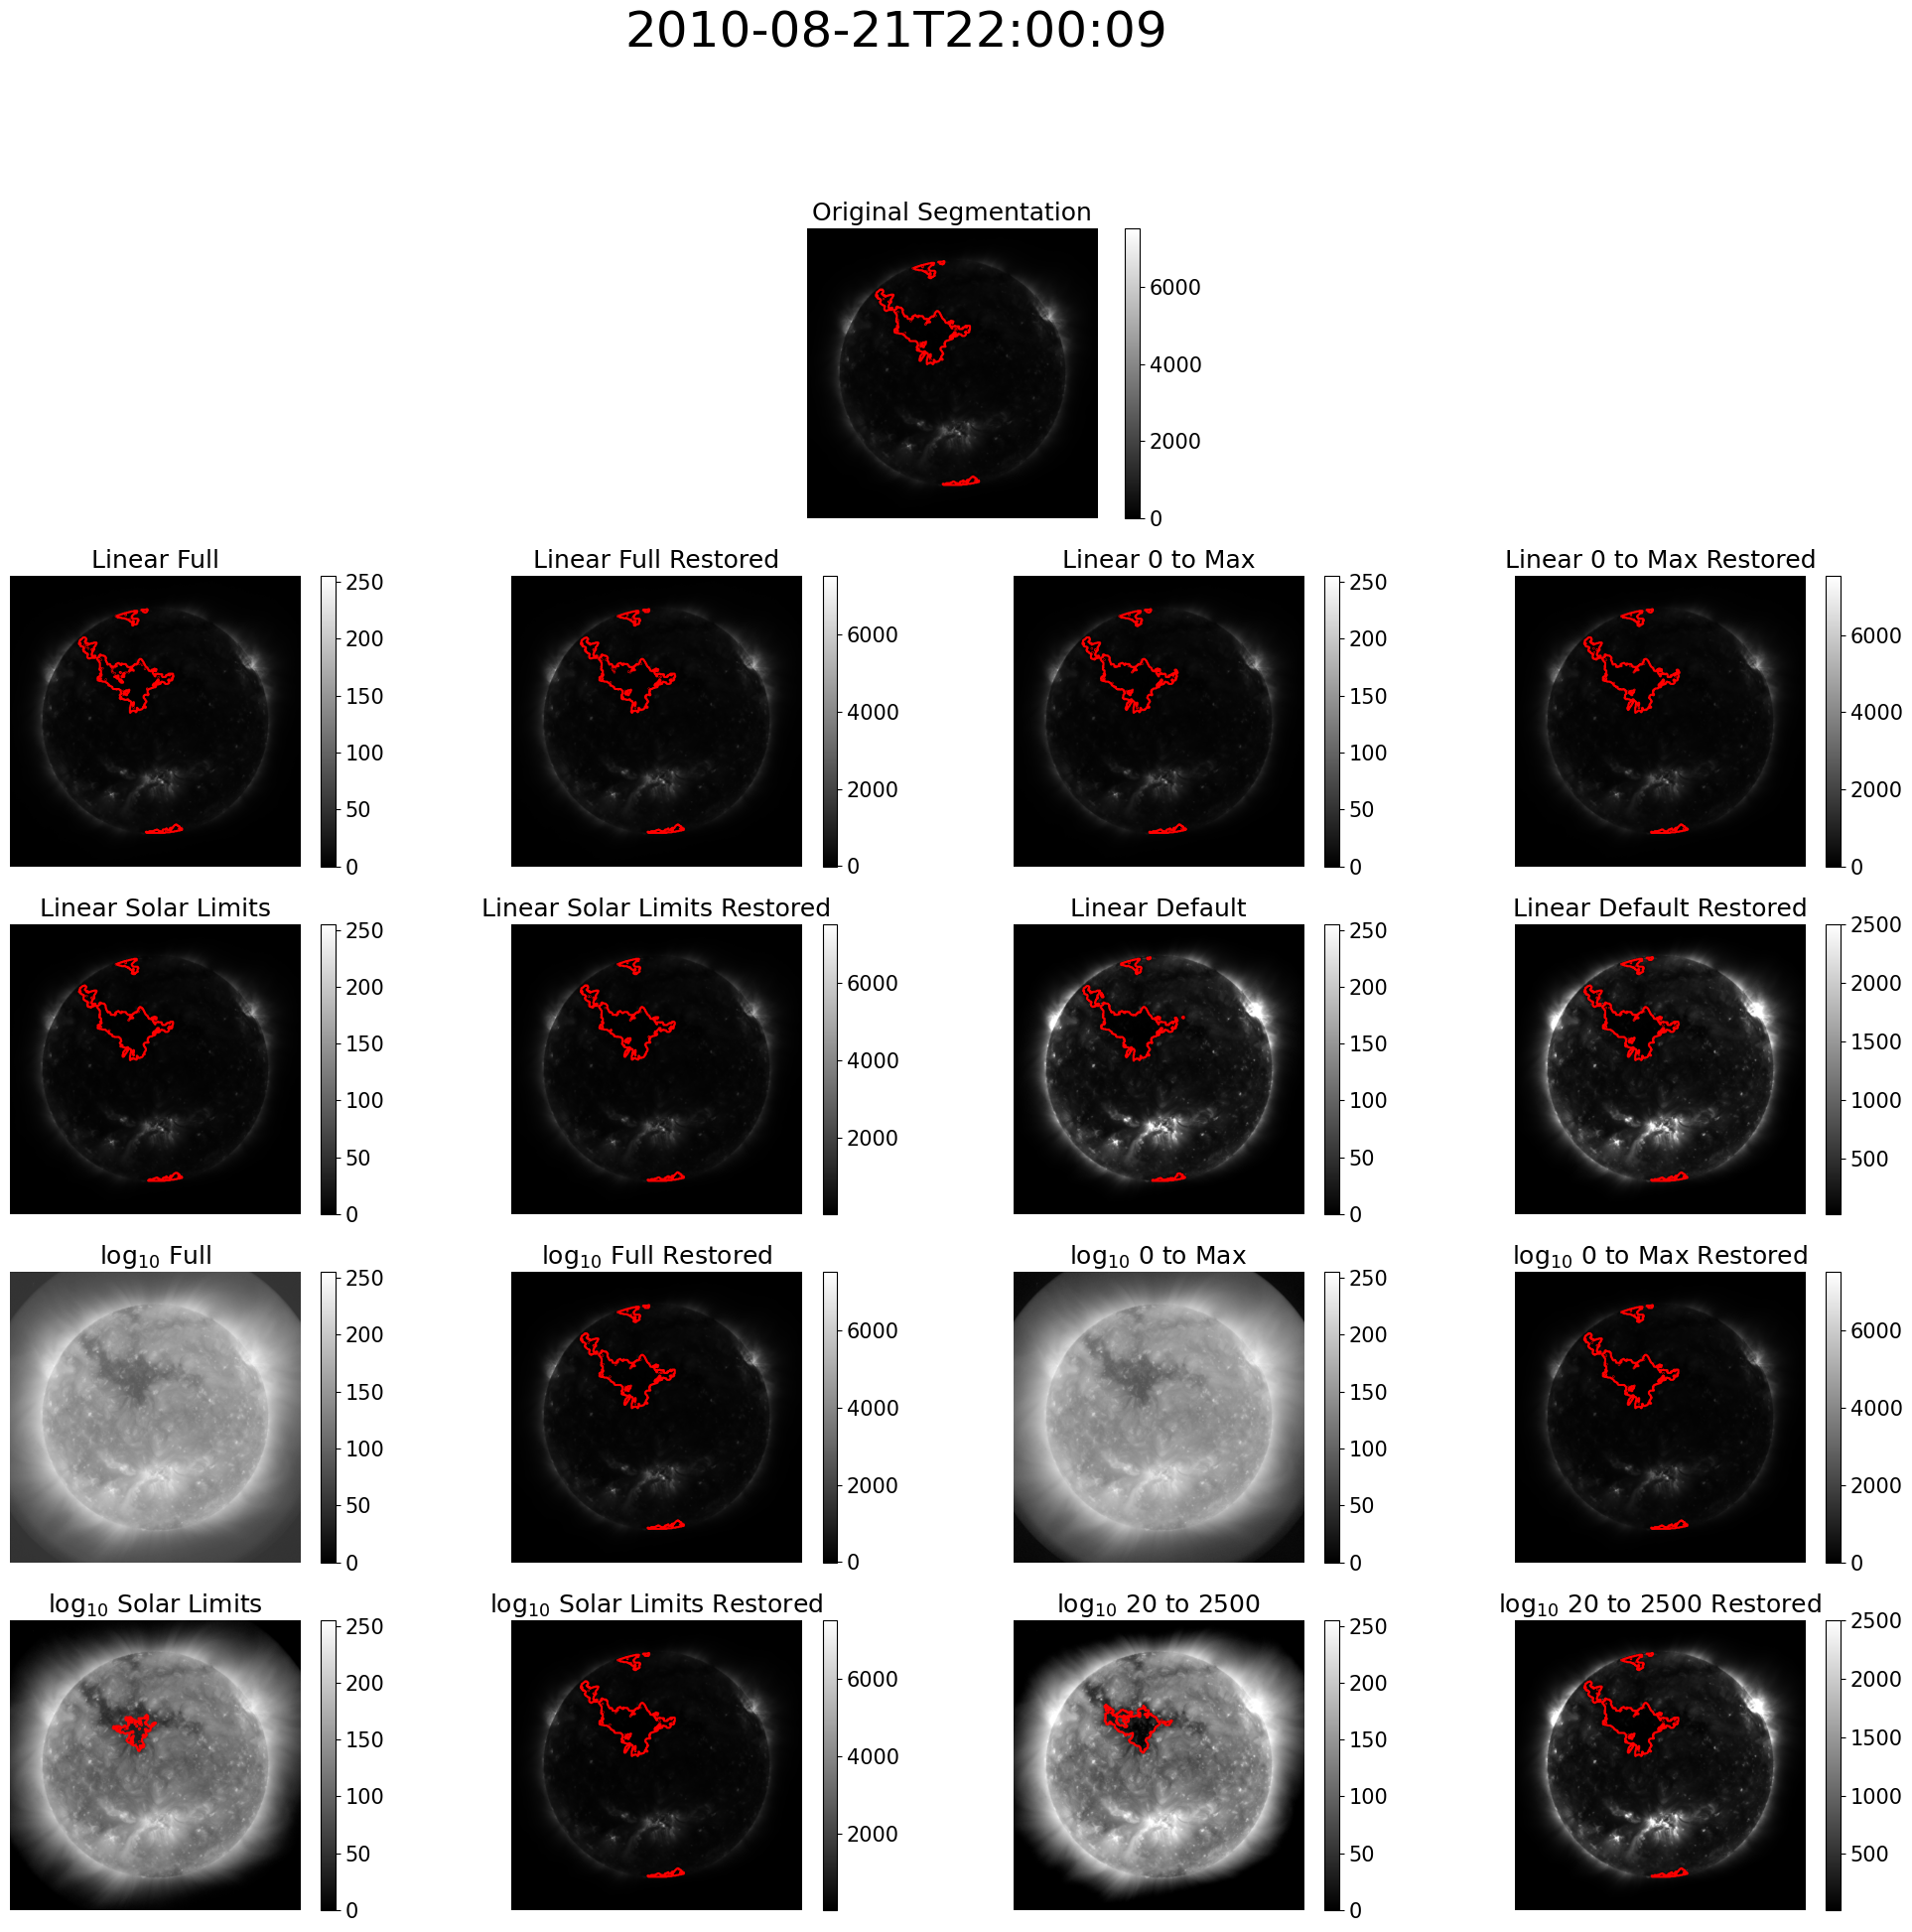

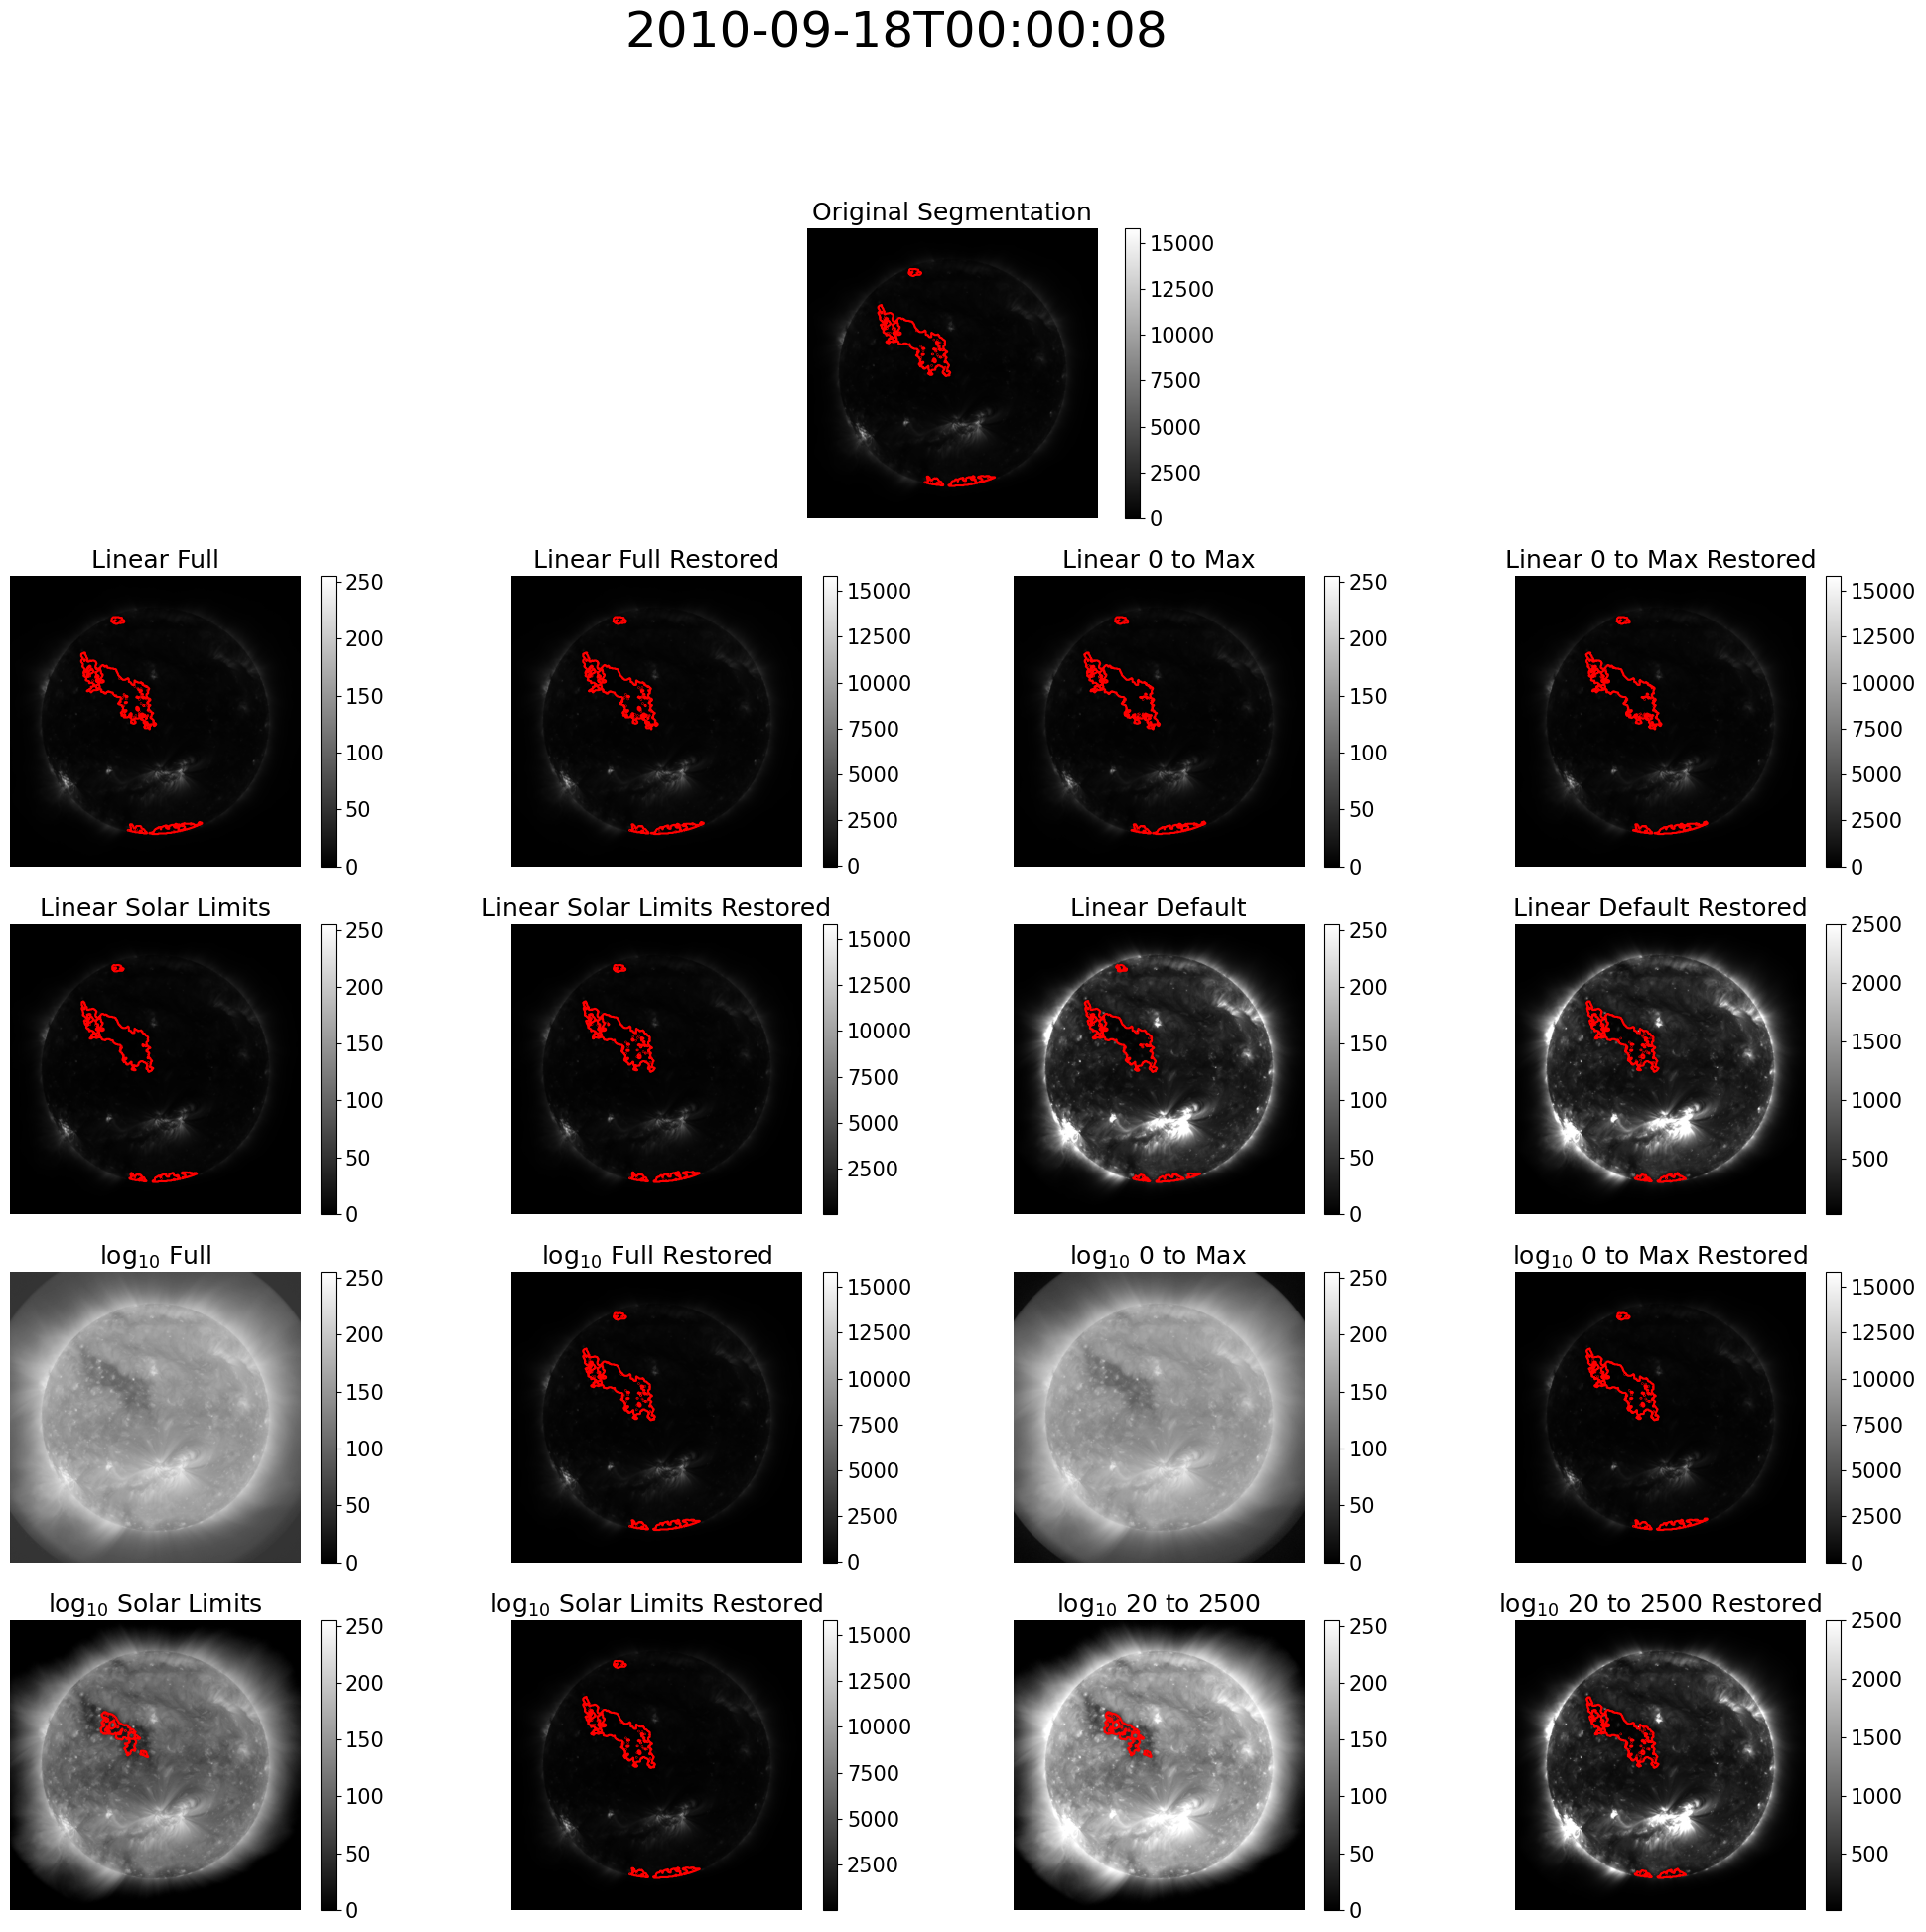

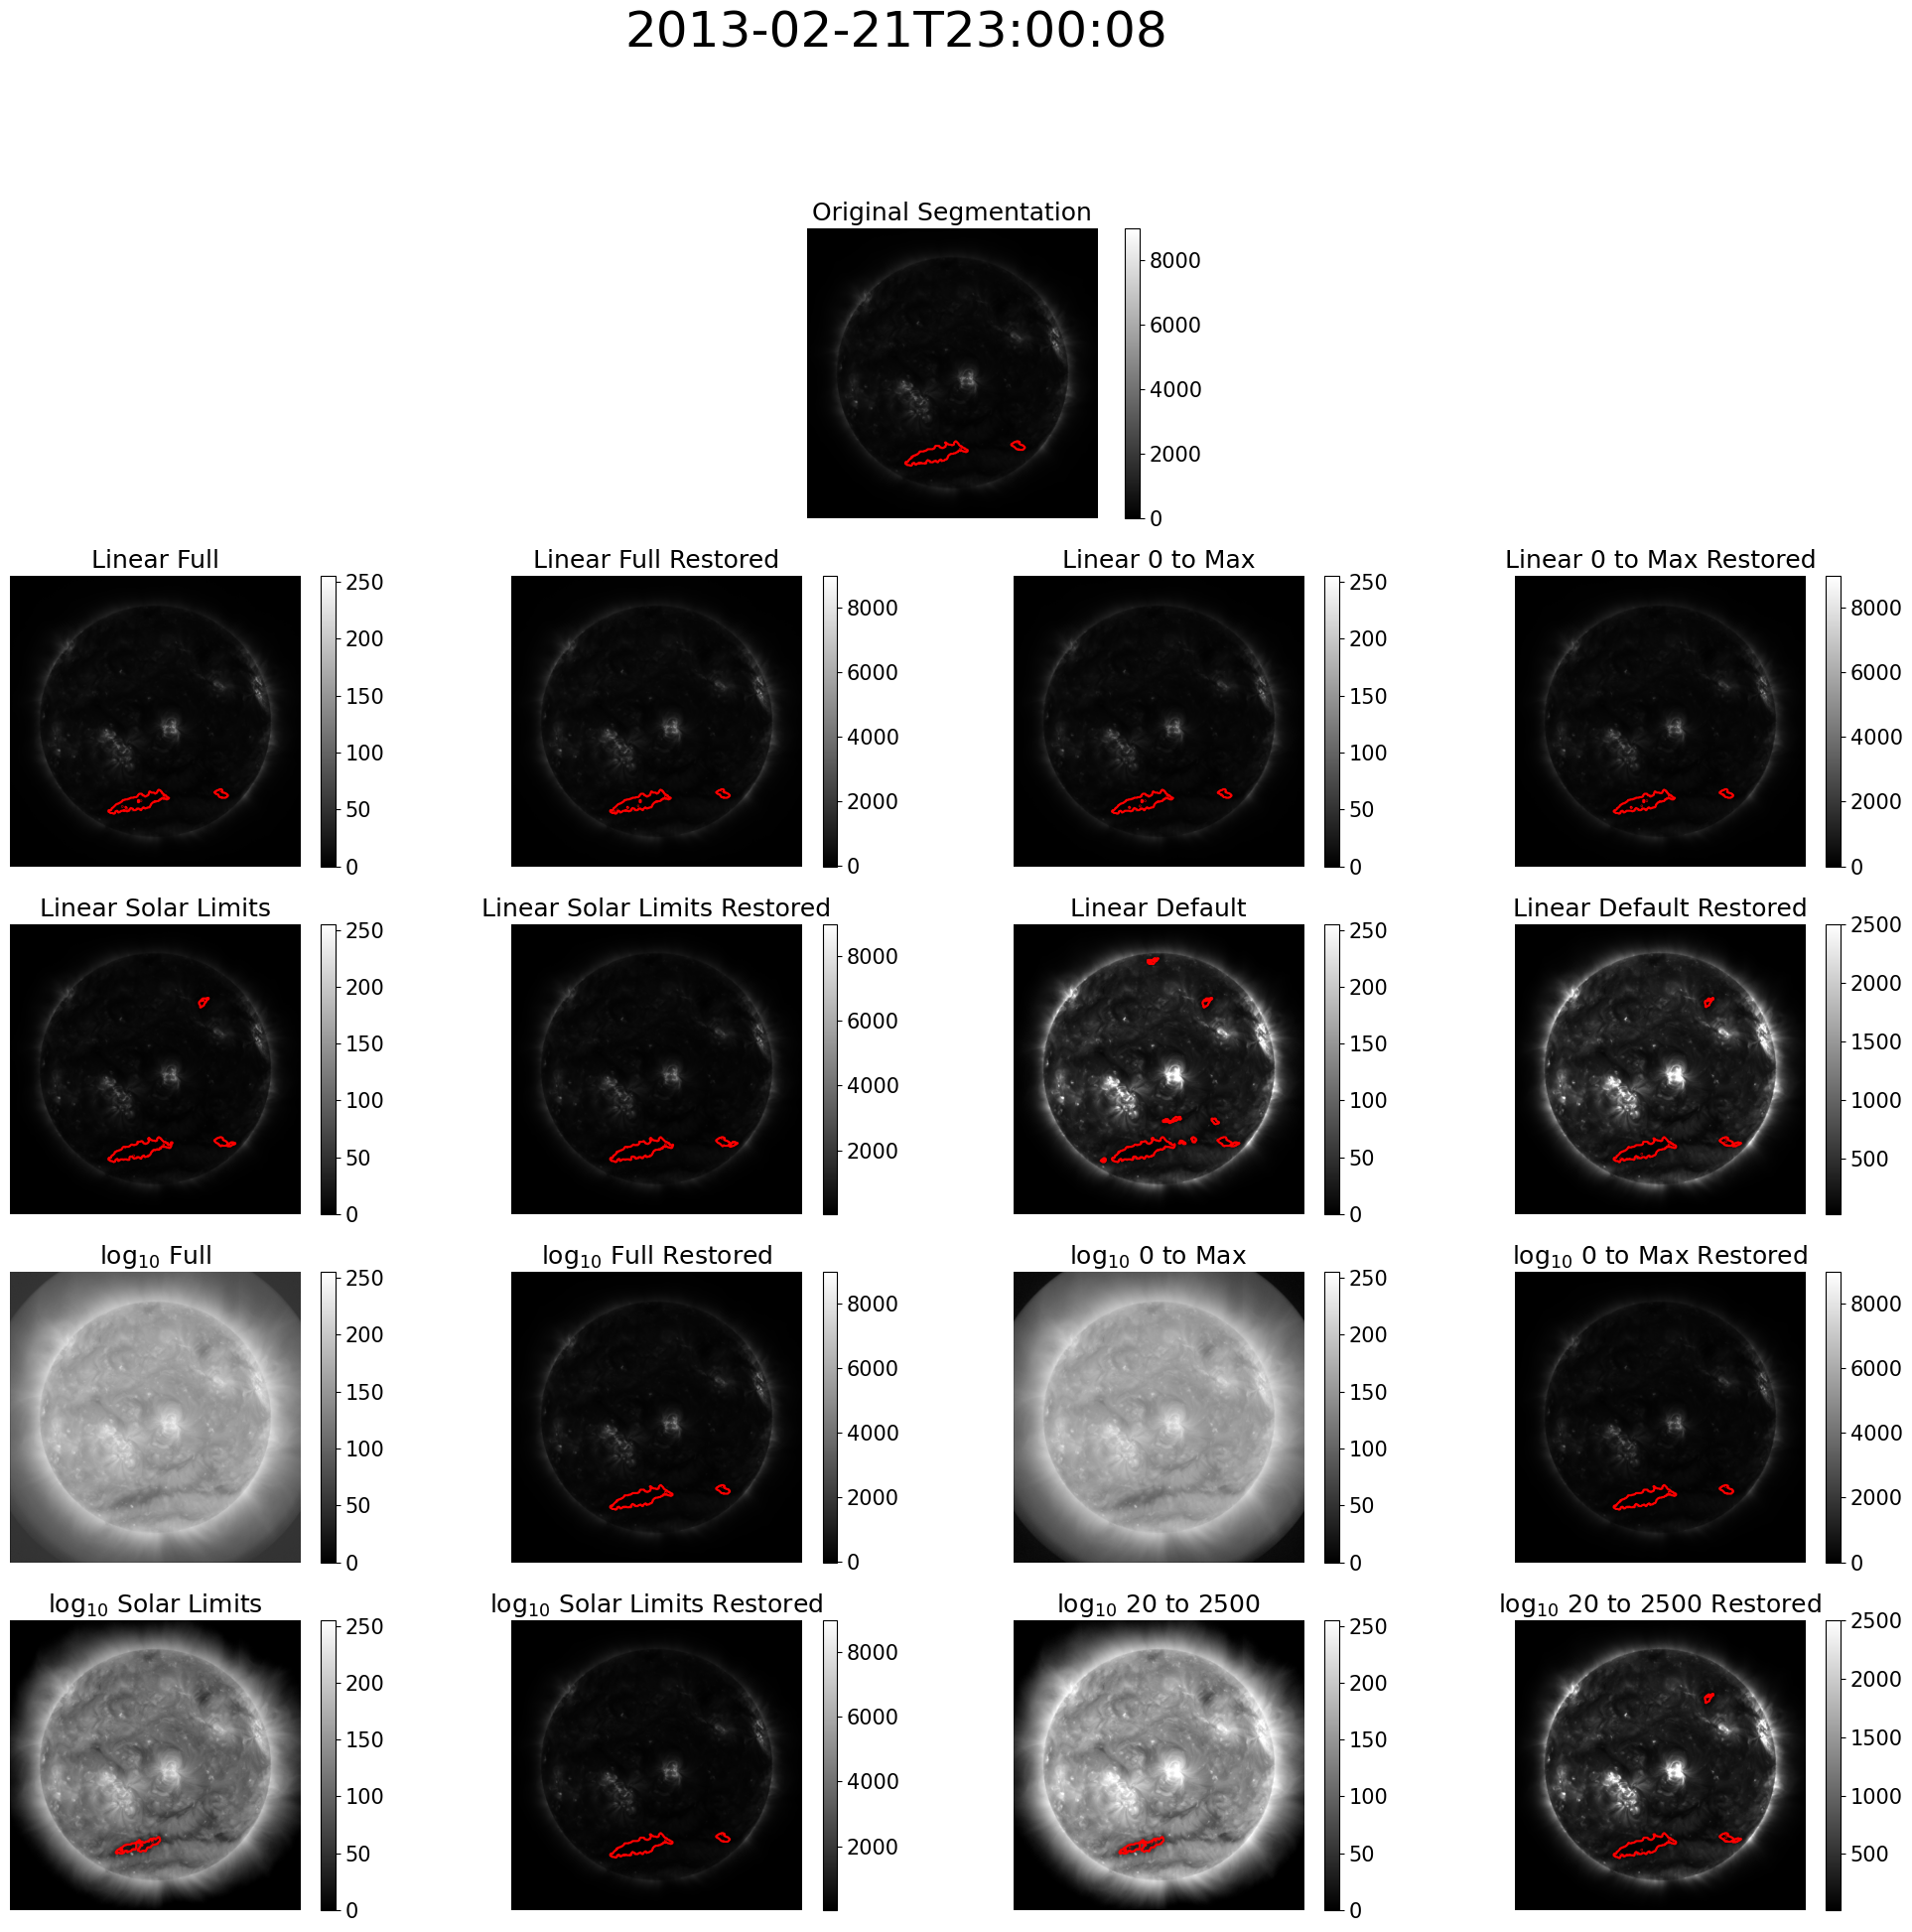

In [5]:
for ImageName in ImageNames:
    
    # Get File Times
    time = dmt.timeFormat(dmt.timeFromFilenameAIA(ImageName))
    
    # Open File
    I,Idsp,H = openAIA(dataset + ImageName)
    
    # Open Original Segmentation
    ACWEfile = ImageName.split('/')[0]+'/'+ImageName.split('/')[1]+'/'
    ACWEfile = glob.glob(saveFolderDefault+ACWEfile+'*'+os.path.basename(ImageName)+'*')[0]
    H,AH,SegC = acweSaveSeg_v5.openSeg(ACWEfile)
    
    # Upscale
    segc = acweRestoreScale.upscale(SegC,AH)
    
    # Get Figure Size
    figSize = len(scaleTypes) + 1
    figSize = int(np.ceil(np.sqrt(figSize)))
    
    # Generate Figure
    plt.figure(figsize=[25,22])
    plt.rcParams.update({'font.size': 30})
    plt.suptitle(time)
    plt.rcParams.update({'font.size': 15})
    plt.subplot(5,3,2)
    plt.imshow(np.flip(I,axis=0),cmap='gray')
    plt.colorbar()
    plt.contour(np.flip(segc,axis=0),0,colors='r')
    plt.title('Original Segmentation')
    plt.axis(False)
    
    # cycle through scaleTypes
    for i in range(len(scaleTypes)):
        
        # Define Scale type
        scaleType = scaleTypes[i]
        
        # Determin Scale Process
        Imin = scaleType[0];Imax = scaleType[1]
        if Imin == 'Imin':   # Image Minimum
            Imin = np.min(I)
        elif Imin == 'Smin': # Minimum Value on Solar Disk
            Ishape = np.asarray(I.shape)
            c_mask = make_circle_mask(Ishape/2.,Ishape,H['R_SUN'])
            Imin = np.min(I[c_mask])
        if Imax == 'Imax':   # Image Maximum
            Imax = np.max(I)
        elif Imax == 'Smax': # Maximum Value on Solar Disk
            Ishape = np.asarray(I.shape)
            c_mask = make_circle_mask(Ishape/2.,Ishape,H['R_SUN'])
            Imax = np.max(I[c_mask])
                
        # Scale (and Unscale)
        Itmp = pngScale2.scale(I,scaleType[2],Imin,Imax)
        if scaleType[3]:
            Itmp = pngScale2.unScale(Itmp,scaleType[2],Imin,Imax)
        
        # Open Corrisponding Segmentation
        ACWEfile = ImageName.split('/')[0]+'/'+ImageName.split('/')[1]+'/'
        ACWEfile = glob.glob(saveFolderIntInv+ACWEfile+'*'+scaleType[-2]+os.path.basename(ImageName)+'*')[0]
        H,AH,SegC = acweSaveSeg_v5.openSeg(ACWEfile)
        
        # Upscale
        segc = acweRestoreScale.upscale(SegC,AH)
        
        # Scale title
        title = scaleType[-1]
        
        # Generate Figure
        plt.subplot(5,4,5 + i)
        plt.imshow(np.flip(Itmp,axis=0),cmap='gray')
        plt.colorbar()
        plt.contour(np.flip(segc,axis=0),0,colors='r')
        plt.title(title)
        plt.axis(False)
    
    # Save and Show Figure
    title = 'IntensitySample.' + time + '.png'
    title = saveDirectory + title
    plt.savefig(title)
    plt.show()